In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [19]:
# Try a more targeted postprocessing
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver

In [3]:
import six
six.moves.reload_module(unstructured_grid)

<module 'stompy.grid.unstructured_grid' from '/home/rusty/src/stompy/stompy/grid/unstructured_grid.py'>

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [4]:
class Experiment:
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022a"
    sun_base_dir="/opt2/sfb_ocean/suntans/runs"
    hydro_timestamps=None
    
    def __init__(self):
        self.ptm_run_patt=os.path.join(self.ptm_base_dir,"chunk??","20??????")
        self.sun_patt=os.path.join(self.sun_base_dir,"merged_022_20??????")
        # does take a second
        self.init_hydro_timestamps()

    @memoize.imemoize()
    def run_paths(self):
        runs=glob.glob(self.ptm_run_patt)
        runs.sort()
        return runs
    @memoize.imemoize()
    def sun_paths(self):
        sun_runs=glob.glob(self.sun_patt)
        sun_runs.sort()
        return sun_runs
    @memoize.imemoize()
    def grid(self):
        """
        To minimize the amount of data required, just use
        the ptm average output, rather than loading the
        suntans input.
        """
        hydro_path=self.sun_paths()[0]
        ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
        g=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
        ptm_ds.close() # safe?   
        return g
        
    def runs(self,criteria=None):
        result=[Run(path=p,experiment=self) 
                for p in self.run_paths()]
        if criteria is not None:
            result=[r for r in result if r.satisfies(criteria)]
        print("Narrowed to %d runs"%(len(result)))
        return result
    def runs_map_reduce(self,
                        map_func=lambda r: r,
                        reduce_func=lambda values: values,
                        criteria=None):
        return reduce_func([map_func(r) 
                            for r in utils.progress(self.runs(criteria=criteria),
                                                    msg="Runs %s")])
    def all_group_names(self):
        def mf(r):
            return r.group_names()
        def rf(lol):
            return [x for l in lol for x in l]
        return self.runs_map_reduce(map_func=mf,reduce_func=rf)
    def all_groups(self):
        def mf(r):
            grps=r.groups()
            return grps
        def rf(lol):    
            return [x for l in lol for x in l]
        return self.runs_map_reduce(map_func=mf,reduce_func=rf)
    def query_particles(self,criteria):
        """
        criteria: t_min, t_max ~ np.datetime64
          behaviors: list of strings, 'down5000','none',etc.
          sources: list of strings, shortened names.
        returns dataframe.
        """
        def query_run(run):
            print(f"query_particles.query_run({run.path})")
            return run.query_particles(criteria)
        return self.runs_map_reduce(criteria=criteria,
                                    map_func=query_run,
                                    reduce_func=lambda values: pd.concat(values))
    def add_cells(self,df,fallback=True):
        """
        add a 'cell' column to the given dataframe, based on
        coordinates in df['x0'], df['x1'], and self.grid.
        if 'cell' already exists, do nothing.
        
        fallback: if True, particles that appear to fall outside the grid
        will get the closest cell.
        """
        if 'cell' in df.columns: return
        grid=self.grid()
        pnts=df[['x0','x1']].values
        cell=grid.points_to_cells(pnts)
        
        if fallback:
            missing=(cell<0)
            cell[missing]=grid.points_to_cells(pnts[missing],method='cells_nearest')
        
        df['cell']=cell
    def add_z_bed(self,df):
        self.add_cells(df)
        df['z_bed']=self.grid().cells['z_bed'][df['cell'].values]

    def open_hydro_ds(self,idx):
        return xr.open_dataset(os.path.join(self.sun_paths()[idx],
                                            "ptm_average.nc_0000.nc"))

    def init_hydro_timestamps(self):
        N=len(self.sun_paths())

        self.hydro_timestamps=np.zeros((N,2), "<M8[ns]") 
        # For starters, just scan the list to populate time stamps.
        for run_idx in range(N):
            ds=self.open_hydro_ds(run_idx)
            t=ds.Mesh2_data_time
            self.hydro_timestamps[run_idx,0]=t.values[0]
            self.hydro_timestamps[run_idx,1]=t.values[-1]
            ds.close()

    def time_to_hydro_index(self,t):
        N=self.hydro_timestamps.shape[0]
        # search on ending to avoid one-off correction.
        idx=np.searchsorted(self.hydro_timestamps[:,1],t).clip(0,N-1)
        assert t>=self.hydro_timestamps[idx,0]
        assert t<=self.hydro_timestamps[idx,1]
        return idx

    def add_z_surface(self,particles):
        """
        particles: dataframe with 'time' and 'cell'
        columns.
        adds 'z_surface' as a column with the elevation of the
        water surface at the particle time, linearly interpolated.

        It is possible but rare for particle['z'] values to be
        above z_surface (and below z_bed) but so far this does not
        appear to be a bug in this code. Rather, the cell mapping
        code is approximate when a point is not clearly within any
        cell polygon.  And in a few cases it appears the particle
        isn't in the domain.
        """
        p_time=particles['time'].values
        p_order=np.argsort(p_time)
        p_order_time=p_time[p_order]
        p_order_cell=particles['cell'].values[p_order]

        t_min=p_time.min()
        t_max=p_time.max()

        # def hydro_ds(self,t):
        idx0=self.time_to_hydro_index(t_min)
        idxN=self.time_to_hydro_index(t_max)

        # hold the results, constructed in time order
        p_order_eta=np.nan*np.zeros(len(particles),np.float32)

        def extract_eta(ds,p_time,p_cell):
            """
            ds: dataset for a chunk of a hydro run
            p_time: times, must fall within ds
            p_cell: cells corresponding to the particle times

            returns: eta values interpolated from ds at the given times, and
            extracted for the given cells.
            """
            ds_time=ds.Mesh2_data_time.values
            p_eta=np.nan*np.ones(len(p_time))
            # waterlevel is instantaneous, and we can linearly interpolate
            # between timesteps. Particles are output at 0.25h or 0.5h intervals,
            # so it doesn't take too many different interpolations.
            for t_grp,part_idxs in utils.progress(utils.enumerate_groups(p_time)):
                tA=ds_time.searchsorted(t_grp)
                assert tA<len(ds_time),"Seems to step off the end of the data"
                # For an exact match, tA is the step we want.
                if ds_time[tA]==t_grp: # good
                    eta=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA).values
                else:
                    # Linearly interpolate:
                    assert tA+1<len(ds_time)
                    etaA=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA).values
                    etaB=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA+1).values
                    theta=(t_grp-ds_time[tA])/(ds_time[tA+1] - ds_time[tA])
                    assert theta>=0
                    assert theta<=1.0
                    print(f"Theta: {theta}")
                    eta=(1-theta)*etaA[0,:] + theta*etaB
                p_eta[part_idxs]=eta[p_cell[part_idxs]]
            return p_eta

        for idx in range(idx0,idxN+1):
            # Iterate over hydro runs
            # Bad naming of variables.
            idx_start,idx_stop=self.hydro_timestamps[idx]

            # Edge cases?
            #  for particles times [x,x,x,y,y,y,z,z,z]
            #  and idx_start=x, idx_stop=z
            #  particle time falls on the first step of output:
            #  then order_start will 
            order_start=p_order_time.searchsorted(idx_start,side='left')
            order_stop =p_order_time.searchsorted(idx_stop,side='right')
            if order_start==order_stop:
                print("Empty slice")
                continue

            part_slc=slice(order_start,order_stop)
            assert np.all( p_order_time[part_slc]>=idx_start )
            assert np.all( p_order_time[part_slc]<=idx_stop  )

            print(f"Would load {idx}")

            ds=self.open_hydro_ds(idx)

            eta_slc=extract_eta(ds,
                                p_order_time[part_slc],
                                p_order_cell[part_slc])
            p_order_eta[part_slc]=eta_slc
        assert np.all(np.isfinite(p_order_eta))
        # Undo the sort to assign back to the particles:
        particles['z_surface']=p_order_eta[np.argsort(p_order)]


    
        
class Run:
    experiment=None
    path=None
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
    def group_names(self):
        bin_out_fns=glob.glob(os.path.join(self.path,"*_bin.out"))
        group_names=[os.path.basename(p).replace('_bin.out','') for p in bin_out_fns]
        return group_names
    @memoize.imemoize()
    def groups(self):
        return [Group(run=self,name=name) for name in self.group_names()]
    def satisfies(self,criteria):
        if 't_min' in criteria and self.t_max()<criteria['t_min']:
            return False
        if 't_max' in criteria and self.t_min()>criteria['t_max']:
            return False
        return True
    @memoize.imemoize()
    def ptm_config(self):
        return ptm_config.PtmConfig.load(self.path)
    def t_max(self):
        "Maximum time of particle outputs for the run."
        return self.ptm_config().end_time
    def t_min(self):
        "Minimum time of particle outputs."
        # relies on knowing that all groups follow the same start/end 
        # within a run
        return self.groups()[0].t_min()
    def query_particles(self,criteria):
        results=[g.query_particles(criteria)
                 for g in utils.progress(self.groups(),msg="  Groups %s")
                 if g.satisfies(criteria)]
        if results:
            df=pd.concat(results)
            df['run']=self.path
            return df
        else:
            return pd.DataFrame()
     
class Group:
    run=None
    name=None
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        m=re.match(r'(.*)_((up|down|none)\d*)_rel(\d+)',self.name)
        self.source,self.behavior,self.release_date=m.group(1),m.group(2),m.group(4)
    def satisfies(self,criteria):
        if 'sources' in criteria and self.source not in criteria.sources:
            return False
        if 't_min' in criteria and self.t_max() < criteria['t_min']:
            return False
        if 't_max' in criteria and self.t_min() > criteria['t_max']:
            return False
        if 'behaviors' in criteria and self.behavior not in criteria.behaviors:
            return False
        return True
    @memoize.imemoize()
    def t_max(self):
        return self.run.t_max()
    @memoize.imemoize()
    def t_min(self):
        release_log_fn=os.path.join(self.run.path,self.name+".release_log")
        with open(release_log_fn,'rt') as fp:
            rel_date,rel_time=fp.readline().strip().split()[-2:]
        return np.datetime64(rel_date+" "+rel_time)
    # Try non-instance memoize to manage cache better.
    @memoize.memoize(lru=20)
    def ptm_bin(self):
        return ptm_tools.PtmBin(fn=os.path.join(self.run.path,self.name+"_bin.out"))
    @memoize.imemoize()
    def release_log(self):
        df_rel=ptm_tools.release_log_dataframe(fn=os.path.join(self.run.path,self.name+".release_log"))
        # release has id and gid. So far they are always the same
        # Trust, but verify.
        assert np.all(df_rel['id'].values==df_rel['gid'].values),"Invariant check"
        return df_rel
    
    def query_particles(self,criteria):
        # Could be faster by using index instead of bin file
        pbf=self.ptm_bin()
        times=np.array( [utils.to_dt64(t) for t in pbf.time] )
        sel=np.ones(len(times),np.bool8)
        if 't_min' in criteria:
            sel=sel&(times>=criteria['t_min'])
        if 't_max' in criteria:
            sel=sel&(times<=criteria['t_max'])

        all_particles=[]
        for ts in np.nonzero(sel)[0]:
            datenum,particles=pbf.read_timestep(ts)
            t=utils.to_dt64(datenum)
            #particles=self.filter_particles(particle,criteria)
            #df=pd.DataFrame(particles) # Can't deal with vectors
            df=pd.DataFrame()
            df['id']=particles['id']
            df['x0']=particles['x'][:,0]
            df['x1']=particles['x'][:,1]
            df['x2']=particles['x'][:,2]
            df['active']=particles['active']
            # Avoid keeping all this memmap'd data around
            del particles
            df['time']=t
            all_particles.append(df)
        if len(all_particles):
            df=pd.concat(all_particles)
            df['group']=self.name
            
            # Assign release times
            # If this is slow, could verify that release_log index 
            # is dense, and do this in numpy
            df_rel=self.release_log().set_index('id') # id vs gid?
            rel_times=df_rel.loc[ df['id'].values,'date_time']
            df['rel_time']=rel_times.values
            
            return df
        else:
            return pd.DataFrame()
                
experiment=Experiment()
runs=experiment.runs()
print(f"{len(runs)} runs found")
groups=experiment.all_groups()
print(f"{len(groups)} groups total")


Narrowed to 124 runs
124 runs found
Narrowed to 124 runs
10633 groups total


In [6]:
%%time
criteria=dict(t_min=np.datetime64("2017-07-09 23:00"),
              t_max=np.datetime64("2017-07-10 02:00"),
              behavior='up5000')

particles=experiment.query_particles(criteria=criteria)
print(f"Found {len(particles)} particles")
# Promising:
# Can query 1M particles in 4s. That's 4h of one run.
# In this case, 8 runs satisfy the time slice.
# Cold start, queries 4.5M particles over 8 runs in 70s.
# Warm start, 28s.

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Narrowed to 12 runs
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20170620)


INFO:utils:Runs 1/12


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20170630)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20170710)


INFO:utils:Runs 3/12


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk01/20170620)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk01/20170630)


INFO:utils:Runs 5/12


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk01/20170710)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk02/20170620)


INFO:utils:Runs 7/12


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk02/20170630)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk02/20170710)


INFO:utils:Runs 9/12


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20170620)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20170630)


INFO:utils:Runs 11/12


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20170710)
Found 6574782 particles
CPU times: user 50.7 s, sys: 1.9 s, total: 52.6 s
Wall time: 54 s


In [7]:
%%time
try:
    del particles['cell']
except KeyError:
    pass
experiment.add_z_bed(particles) # 12s for 1.8M

CPU times: user 44.6 s, sys: 667 ms, total: 45.3 s
Wall time: 45.3 s


In [ ]:
fig,ax=plt.subplots()
experiment.grid().plot_edges(color='k',lw=0.5,ax=ax)
sel=slice(None,None,20)
scat=ax.scatter(particles['x0'].values[sel],
           particles['x1'].values[sel], 
           5,particles['z_bed'].values[sel],
           cmap='jet',zorder=2)
scat.set_clim([-20,0])
ax.axis('tight')
ax.axis('equal')
ax.axis('off')
fig.tight_layout()

In [ ]:
particles.head()

In [ ]:
age=(particles['time']-particles['rel_time'])/np.timedelta64(1,'s')

In [ ]:
fig,ax=plt.subplots(1,1)
g.plot_edges(color='k',lw=0.5,alpha=0.5,ax=ax)
ax.set_position([0,0,1,1])
ax.axis('off')
ax.axis('tight')
ax.axis('equal')

sel=slice(None,None,20)
x=particles['x0']
y=particles['x1']
ax.scatter(x[sel],y[sel],4,age[sel],alpha=0.2,cmap='jet')

Status
--

Reasonable performance reading data single-threaded.

Next steps:

1. Have Experiment or Run filter on z and/or add relative z position
   to results.
2. Have Group (or maybe a Source class) add weighting by forcing data.
3. How hard would it be to parallelize at some level?  Don't do this too
   early, but take a look in case it's easy.
4. Recreate some of the figures from before, including on-grid smoothing.
5. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.

In [11]:
experiment.add_z_surface(particles)

Would load 2


6574782 particles in query
67 particles above surface
90 particles below bed
Worst below bed z-z_bed=-2.7397222704573494
Worst above surface z-z_surface=1.0800877296447755


<IPython.core.display.Javascript object>


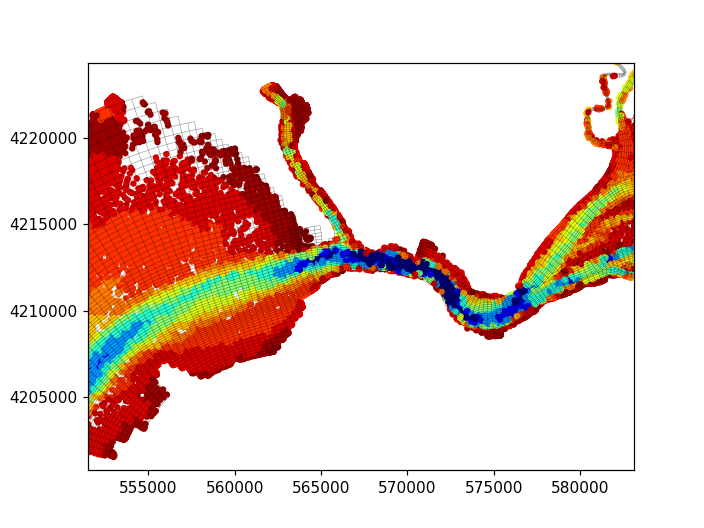

(335896.809213, 622757.585107, 3970068.94815, 4307931.05185)

In [28]:
# How do we do? 
print(f"{len(particles)} particles in query")
above=(particles['x2']>particles['z_surface']).sum()
below=(particles['x2']<particles['z_bed']).sum()
print(f"{above} particles above surface")
print(f"{below} particles below bed")
z_lowest=(particles['x2']-particles['z_bed']).min()
z_highest=(particles['x2']-particles['z_surface']).max()
print(f"Worst below bed z-z_bed={z_lowest}")
print(f"Worst above surface z-z_surface={z_highest}")

g=experiment.grid()

fig,ax=plt.subplots()
g.plot_edges(color='k',lw=0.4,alpha=0.4)

if 0: # plot 'bad' particles
    above=(particles['x2']>particles['z_surface']).values
    below=(particles['x2']<particles['z_bed']).values

    ax.plot( particles['x0'][above], particles['x1'][above], marker='o', lw=0.0, color='tab:red')
    ax.plot( particles['x0'][below], particles['x1'][below], marker='o', lw=0.0, color='tab:blue')

    all_cells=np.unique(particles.loc[above|below,'cell'])
    g.plot_cells(mask=all_cells,color='tab:green',alpha=0.15)
    
if 1: 
    slc=slice(None,None,20)
    scat=ax.scatter(particles['x0'].values[slc],
                    particles['x1'].values[slc],
                    10, particles['z_bed'].values[slc],cmap='jet')
    scat.set_clim([-25,-5])
ax.axis('tight')
ax.axis('equal')


In [34]:
# Weighting w.r.t. source, release time, behavior
# This should be implemented by Group
print("Source:",groups[0].source)
print("Behavior:",groups[0].behavior)
print("Group name:",groups[0].name)

grp_particles=groups[0].query_particles(criteria)
len(grp_particles)

# HERE


Source: San_Lorenzo_C
Behavior: down50000
Group name: San_Lorenzo_C_down50000_rel20170620


9600

In [40]:
experiment.load_data=xr.open_dataset("../loads/plastic_loads-7classes-v05.nc")

In [41]:
# 1. Associate a group with load information:
self=groups[0]
load_data=self.run.experiment.load_data
if source in


In [42]:
load_data

<xarray.Dataset>
Dimensions:            (category: 6, pathway: 2, source: 9, w_s: 7)
Coordinates:
  * pathway            (pathway) object 'effluent' 'stormwater'
  * category           (category) object 'Fiber' 'Fiber Bundle' ... 'Sphere'
  * w_s                (w_s) float64 -0.05 -0.005 -0.0005 0.0 0.0005 0.005 0.05
  * source             (source) object 'CCCSD' 'EBDA' ... 'SUNN' 'stormwater'
Data variables:
    n_blank_particles  (pathway, category) int64 ...
    n_blank_samples    (pathway, category) int64 ...
    blank_rate         (pathway, category) float64 ...
    total_volume       (source) float64 ...
    n_samples          (source) float64 ...
    count_w_s          (source, category, w_s) int32 ...
    count_no_w_s       (source, category) int32 ...
    conc_raw           (source, category, w_s) float64 ...
    source_pathway     (source) object ...
    conc               (source, category, w_s) float64 ...
    conc_noclip        (source, category, w_s) float64 ...
    conc_